In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    top_k_accuracy_score,
)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tobiasbueck/multilingual-customer-support-tickets")

print("Path to dataset files:", path)

100%|██████████| 7.05M/7.05M [00:00<00:00, 91.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tobiasbueck/multilingual-customer-support-tickets/versions/9


In [ ]:
import os

# Download latest version
dataset_dir = kagglehub.dataset_download("tobiasbueck/multilingual-customer-support-tickets")

# Find the CSV file within the downloaded directory
for filename in os.listdir(dataset_dir):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(dataset_dir, filename)
        break  # Stop searching after finding the first CSV file

# Now read the CSV file using pandas
df = pd.read_csv(csv_file_path)

In [ ]:
df.head()

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   18539 non-null  object
 1   body      19998 non-null  object
 2   answer    19996 non-null  object
 3   type      20000 non-null  object
 4   queue     20000 non-null  object
 5   priority  20000 non-null  object
 6   language  20000 non-null  object
 7   tag_1     20000 non-null  object
 8   tag_2     19954 non-null  object
 9   tag_3     19905 non-null  object
 10  tag_4     18461 non-null  object
 11  tag_5     13091 non-null  object
 12  tag_6     7351 non-null   object
 13  tag_7     3928 non-null   object
 14  tag_8     1907 non-null   object
dtypes: object(15)
memory usage: 2.3+ MB


,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
count,18539,19998,19996,20000,20000,20000,20000,20000,19954,19905,18461,13091,7351,3928,1907
unique,18539,19998,19996,4,10,3,2,148,204,344,481,578,566,492,386
top,Optimierung Ihrer Datenanalyse-Plattform erlei...,"Sehr geehrte Customer Support-Team, ich schrei...","Sehr geehrter <name>, wir antworten Ihnen auf ...",Incident,Technical Support,medium,en,Technical,Performance,IT,Tech Support,Tech Support,Resolution,Resolution,Documentation
freq,1,1,1,7978,5824,8144,11923,5034,2795,3309,3436,2287,841,417,162


In [ ]:
# Fill and engineer text
df["subject"] = df["subject"].fillna("")
df["body"] = df["body"].fillna("")
tag_cols = [col for col in df.columns if col.startswith("tag_")]
df["tags_combined"] = df[tag_cols].fillna("").agg(" ".join, axis=1)
df["text"] = df["subject"] + " " + df["body"] + " " + df["tags_combined"]
df = df[df["queue"].notna()]

# Encode target
le = LabelEncoder()
df["queue_encoded"] = le.fit_transform(df["queue"])

# Split by language
df_en = df[df["language"] == "en"]
df_de = df[df["language"] == "de"]

# Training function with Top-2 scoring
def train_branch(df_branch, lang_label, label_encoder):
    print(f"\n=== Training SVC Model for {lang_label} ===")
    X = df_branch[["text", "priority", "type"]]
    y = df_branch["queue_encoded"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    text_transformer = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000))
    ])
    categorical_transformer = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer([
        ("text", text_transformer, "text"),
        ("cat", categorical_transformer, ["priority", "type"])
    ])

    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", SVC(C=10, kernel="rbf", class_weight=None, probability=True))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_probs = pipeline.predict_proba(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Top-2 Accuracy:", top_k_accuracy_score(y_test, y_probs, k=2))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return y_test, y_pred, y_probs, label_encoder.classes_

# Run for both languages
y_test_en, y_pred_en, y_prob_en, classes_en = train_branch(df_en, "English", le)
y_test_de, y_pred_de, y_prob_de, classes_de = train_branch(df_de, "German", le)


=== Training SVC Model for English ===
Accuracy: 0.6440251572327044
Top-2 Accuracy: 0.7672955974842768
                                 precision    recall  f1-score   support

           Billing and Payments       0.86      0.80      0.83       260
               Customer Service       0.51      0.62      0.56       372
                General Inquiry       0.80      0.35      0.49        34
                Human Resources       0.96      0.56      0.71        41
                     IT Support       0.64      0.54      0.59       278
                Product Support       0.58      0.59      0.58       447
          Returns and Exchanges       0.86      0.47      0.60       116
            Sales and Pre-Sales       0.66      0.38      0.48        66
Service Outages and Maintenance       0.78      0.57      0.66        88
              Technical Support       0.65      0.76      0.70       683

                       accuracy                           0.64      2385
                  

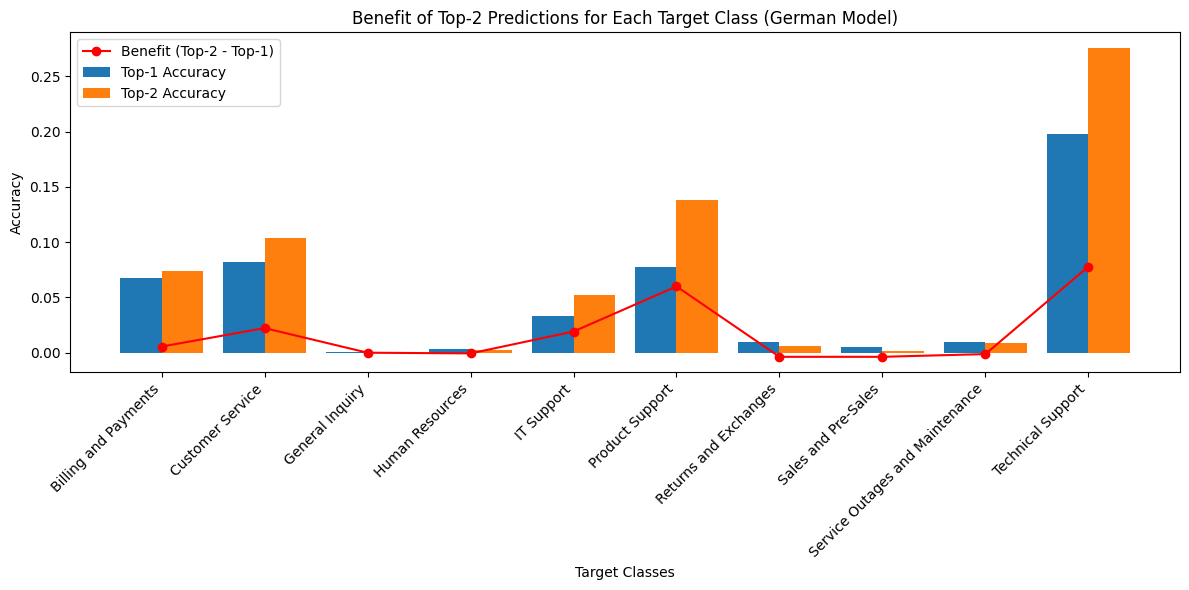

In [ ]:
# Calculate top-1 and top-2 accuracy for each class for the German model
top_1_accuracy_per_class_de = []
top_2_accuracy_per_class_de = []

for i, class_name in enumerate(classes_de):
    top_1_accuracy = np.mean((y_test_de == i) & (y_pred_de == i))
    top_2_accuracy = np.mean((y_test_de == i) & (np.argsort(y_prob_de, axis=1)[:, -2:] == i).any(axis=1))
    top_1_accuracy_per_class_de.append(top_1_accuracy)
    top_2_accuracy_per_class_de.append(top_2_accuracy)

# Calculate the benefit of top-2 predictions for the German model
benefit_de = np.array(top_2_accuracy_per_class_de) - np.array(top_1_accuracy_per_class_de)

# Plot for German model
plt.figure(figsize=(12, 6))
x = np.arange(len(classes_de))
plt.bar(x - 0.2, top_1_accuracy_per_class_de, width=0.4, label="Top-1 Accuracy")
plt.bar(x + 0.2, top_2_accuracy_per_class_de, width=0.4, label="Top-2 Accuracy")
plt.plot(x, benefit_de, color="red", marker="o", label="Benefit (Top-2 - Top-1)")
plt.xticks(x, classes_de, rotation=45, ha="right")
plt.xlabel("Target Classes")
plt.ylabel("Accuracy")
plt.title("Benefit of Top-2 Predictions for Each Target Class (German Model)")
plt.legend()
plt.tight_layout()
plt.show()

Top-1: [np.float64(0.08763102725366877), np.float64(0.0960167714884696), np.float64(0.005031446540880503), np.float64(0.009643605870020965), np.float64(0.06289308176100629), np.float64(0.11069182389937107), np.float64(0.022641509433962263), np.float64(0.010482180293501049), np.float64(0.020964360587002098), np.float64(0.2180293501048218)]
Top-2: [np.float64(0.0909853249475891), np.float64(0.11614255765199162), np.float64(0.004612159329140462), np.float64(0.009224318658280923), np.float64(0.07505241090146751), np.float64(0.16058700209643606), np.float64(0.018448637316561847), np.float64(0.007966457023060796), np.float64(0.01761006289308176), np.float64(0.26666666666666666)]


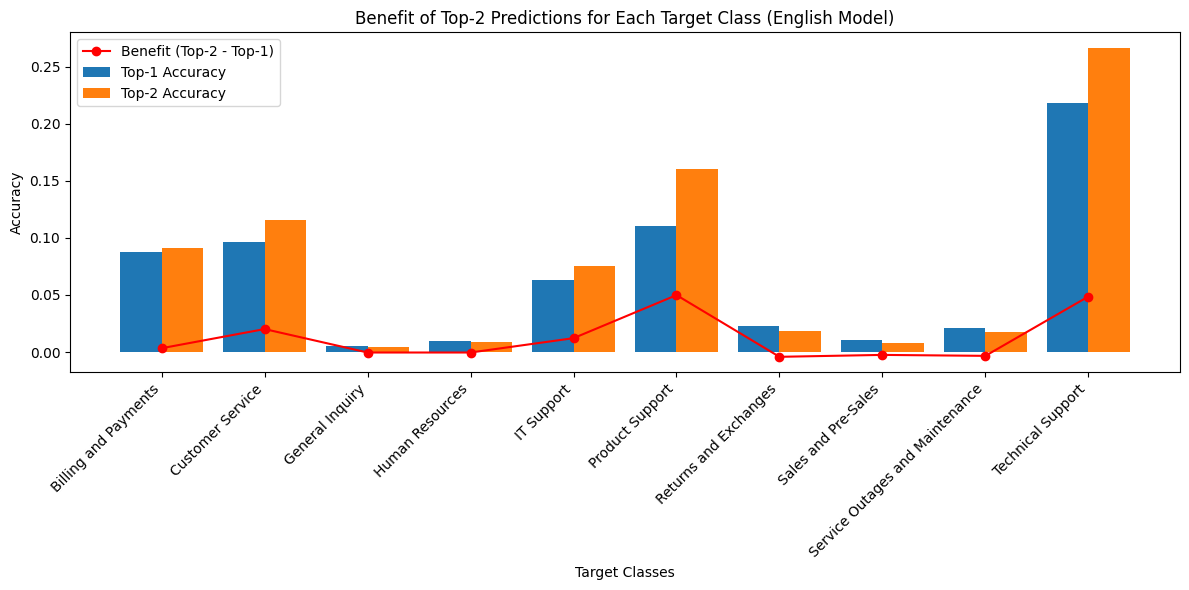

In [ ]:
# Calculate top-1 and top-2 accuracy for each class
top_1_accuracy_per_class_en = []
top_2_accuracy_per_class_en = []

for i, class_name in enumerate(classes_en):
    top_1_accuracy = np.mean((y_test_en == i) & (y_pred_en == i))
    top_2_accuracy = np.mean((y_test_en == i) & (np.argsort(y_prob_en, axis=1)[:, -2:] == i).any(axis=1))
    top_1_accuracy_per_class_en.append(top_1_accuracy)
    top_2_accuracy_per_class_en.append(top_2_accuracy)

# Debug check
print("Top-1:", top_1_accuracy_per_class_en)
print("Top-2:", top_2_accuracy_per_class_en)

# Ensure all lists are the same length
assert len(classes_en) == len(top_1_accuracy_per_class_en) == len(top_2_accuracy_per_class_en), "Length mismatch!"

# Calculate the benefit of top-2 predictions
benefit_en = np.array(top_2_accuracy_per_class_en) - np.array(top_1_accuracy_per_class_en)

# Plot
plt.figure(figsize=(12, 6))
x = np.arange(len(classes_en))

plt.bar(x - 0.2, top_1_accuracy_per_class_en, width=0.4, label="Top-1 Accuracy")
plt.bar(x + 0.2, top_2_accuracy_per_class_en, width=0.4, label="Top-2 Accuracy")
plt.plot(x, benefit_en, color="red", marker="o", label="Benefit (Top-2 - Top-1)")

plt.xticks(x, classes_en, rotation=45, ha="right")
plt.xlabel("Target Classes")
plt.ylabel("Accuracy")
plt.title("Benefit of Top-2 Predictions for Each Target Class (English Model)")
plt.legend()
plt.tight_layout()
plt.show()

